In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from statannot import add_stat_annotation
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from tqdm import tqdm

%matplotlib inline
%load_ext autoreload
%autoreload 2

from utils import quick_load_liuzhong_health_check_data, parse_dict_with_default
from plot_utils import Stack, Scatter, Sankey, BxxPvalue

warnings.filterwarnings("ignore")

df_table1plus, l_consecute_man2p, l_consecute_man3p, df_table1plus_3p_revMM, df_meta_group, rename_dict = quick_load_liuzhong_health_check_data()
workdir = "/cluster/home/bqhu_jh/projects/healthman/analysis/liuzhong/human/clinical/figures"
l_high_lighted_2 = [
    'v000763', 'v9319', 'v000762', 'v002161',
    'HEART.Normal', 'HEART.SinusRhythm', 'HEART.SinusBradycardia', 'HEART.SinusTachycardia',
    'LUNG.GroundGlassOpacity', 'LUNG.SmallNodule', 'LUNG.Nodule', 'LUNG.Normal',
    'v0009', 'v0008', 'v0010', 'v1235',
    'v0023', 'v1970', 'v1164', 'v9046',
    'v9047', 'v9048', 'v9049', 'v9050',
    'v9057', 'v9064', 'v9045', 'v9058',
    'v9059', 'v9060', 'v9061', 'v9062',
    'v9063', 'v9065', 'v9066', 'v9051', 'v9055',
    'v9089', 'v9090', 'v9091', 'v0017',
    'v0045', 'v0022', 'v1162', 'v1940',
    'v1925', 'LIVER.Steatosis', 'v9453', 'v0955',
    'v9461', 'v9462', 'v9464'
]

In [2]:
df_table1plus

variable,birthday,year,month,day,gender,sample_id,v000760,v000761,v002266,v000763,...,v0015,v0016,v0027,v0026,v0032,age,year-month,age_groups,period,period_age
0,1935-08-25,2021,12,24,male,Da4TKCKNjTfO2CE73cGmYsytDz5zY9ZxX1C5OdZIUwx3vQ==,157.2,63.8,NaN,84.0,...,23.10,9.3,13.80,NaN,129.0,86,2021-12,>60,Control-2022,Control-2022_>60
1,1935-09-27,2023,2,14,female,3LMkuxkqQtefLsMjWJ+T/cytDz5zZdZxX1C5ONZKUwh0vA==,152.0,52.5,NaN,71.0,...,7.60,2.8,4.80,4.0,84.0,88,2023-02,>60,Test-2023,Test-2023_>60
2,1935-12-01,2021,6,8,male,5KGUOjagf2QfVhHEPAiW+cytDz5zZ9ZxX1C4M9RMUg53vA==,156.9,67.5,NaN,64.0,...,7.80,4.1,3.70,11.7,93.0,86,2021-06,>60,Control-2021,Control-2021_>60
3,1936-04-03,2022,10,7,female,V/Lh31LCtw8A+AOXAwk4aMytDz5zZdZxX1O5NdROUwhyvQ==,146.9,54.1,NaN,94.0,...,7.90,3.1,4.80,NaN,65.0,86,2022-10,>60,Control-2022,Control-2022_>60
4,1936-10-30,2021,2,5,female,CqpgapqSPchK77fFqauqSsytDz5zY9ZxX1O4MddNUgdy1g==,150.0,56.8,NaN,73.0,...,8.70,3.0,5.70,NaN,71.0,85,2021-02,>60,Control-2021,Control-2021_>60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235676,2001-07-13,2023,6,28,female,cs57W5NzI8055fwwuSj45MytDj97Y9V4XFS5NtVOUg50vQ==,167.0,55.5,NaN,74.0,...,19.30,6.4,12.90,3.8,58.0,22,2023-06,<30,Test-2023,Test-2023_<30
235677,2001-07-31,2023,4,16,female,BNy7GDFnsbqEqur6IFWXpMytDzdxYNV4XFS5NtdMUg50ug==,166.7,55.5,NaN,121.0,...,12.60,4.7,7.90,2.3,77.0,22,2023-04,<30,Test-2023,Test-2023_<30
235678,2001-08-22,2023,1,8,male,e3B0iY01lpqx3/lR3fAU2cyqDjlxYNV4XFS5OdZPUAd3uQ==,180.5,58.5,NaN,91.0,...,38.85,12.2,26.65,5.9,83.0,22,2023-01,<30,Test-2023,Test-2023_<30
235679,2001-12-09,2020,11,14,male,O6Bv8vNp46iIN/C0LFPDSsyoDTxxZ9V4XFS4M9REUQd3tw==,178.5,58.9,NaN,81.0,...,30.90,9.4,21.50,4.7,68.0,19,2020-11,<30,Control-2021,Control-2021_<30


# xgboost Training

## feature engineering

In [3]:
df_t_change = pd.melt(
    df_table1plus_3p_revMM[ ["sample_id", 'HEART.T_change', "period", "month", "age_groups","gender"] ],
    id_vars = ["sample_id", "month", "period", "age_groups", "gender"]
).pivot(index=["sample_id","variable", "month", "age_groups", "gender"], 
        columns="period", values="value").reset_index()

l_t_change_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Control-2022"]==0) & (df_t_change["Test-2023"]==1)
]["sample_id"]

l_t_norm_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==0)
]["sample_id"]

l_t_change_22_23 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Control-2022"]==1) & (df_t_change["Test-2023"]==1)
]["sample_id"]

sub_ = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_norm_2023)]
sub_["group"] = "t-norm_2023"
sub_23 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_2023)]
sub_23["group"] = "t-abnorm_2023"
sub_2223 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_22_23)]
sub_2223["group"] = "t-abnorm_22-23"

df_t_group = pd.concat([sub_, sub_23, sub_2223])
df_t_group["group_each_year"] = df_t_group.apply(lambda x: f"{x['group']}-{x['period']}" , axis=1)
df_t_group["group_num"] = [ 0 if x=="t-norm_2023" else 1 for x in df_t_group["group"] ]
df_t_group

variable,birthday,year,month,period,gender,sample_id,v000760,v000761,v002266,v000763,...,v0027,v0026,v0032,age,year-month,age_groups,period_age,group,group_each_year,group_num
61301,1993-05-22,2021,2,Control-2021,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,155.2,53.0,NaN,102.0,...,5.3,4.1,63.0,28,2021-02,<30,Control-2021_<30,t-norm_2023,t-norm_2023-Control-2021,0
61305,1993-05-22,2022,2,Control-2022,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,94.0,...,5.3,NaN,69.0,29,2022-02,<30,Control-2022_<30,t-norm_2023,t-norm_2023-Control-2022,0
61309,1993-05-22,2023,2,Test-2023,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,90.0,...,5.9,NaN,63.0,30,2023-02,30-45,Test-2023_30-45,t-norm_2023,t-norm_2023-Test-2023,0
37916,1981-11-11,2021,2,Control-2021,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,162.1,70.2,NaN,89.0,...,10.8,NaN,66.0,40,2021-02,30-45,Control-2021_30-45,t-norm_2023,t-norm_2023-Control-2021,0
37918,1981-11-11,2022,2,Control-2022,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,163.6,69.9,NaN,87.0,...,8.9,NaN,61.0,41,2022-02,30-45,Control-2022_30-45,t-norm_2023,t-norm_2023-Control-2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7289,1957-10-20,2022,1,Control-2022,male,vwcGSchg5jsG7SxV3BR7UMytDz5zYtZxWVK4MdZNUg531g==,171.0,75.3,NaN,76.0,...,15.5,8.3,101.0,65,2022-01,>60,Control-2022_>60,t-abnorm_22-23,t-abnorm_22-23-Control-2022,1
7291,1957-10-20,2023,1,Test-2023,male,vwcGSchg5jsG7SxV3BR7UMytDz5zYtZxWVK4MdZNUg531g==,170.0,73.7,NaN,91.0,...,9.9,5.9,102.0,66,2023-01,>60,Test-2023_>60,t-abnorm_22-23,t-abnorm_22-23-Test-2023,1
13345,1964-06-30,2021,2,Control-2021,male,wQmfAKTokYG2TISjjYiWIcytDz5zZdZxWlG5N9dNUQtxuA==,168.0,72.7,NaN,73.0,...,7.0,5.9,72.0,57,2021-02,45-60,Control-2021_45-60,t-abnorm_22-23,t-abnorm_22-23-Control-2021,1
13347,1964-06-30,2022,2,Control-2022,male,wQmfAKTokYG2TISjjYiWIcytDz5zZdZxWlG5N9dNUQtxuA==,NaN,NaN,NaN,74.0,...,5.6,3.6,73.0,58,2022-02,45-60,Control-2022_45-60,t-abnorm_22-23,t-abnorm_22-23-Control-2022,1


## generate xgb input file

In [4]:
# l_core = list(df_meta_group["item_id"])
l_core = l_high_lighted_2
df_23 = pd.DataFrame(df_t_group[df_t_group["period"]=="Test-2023"][l_core].values)
df_22 = pd.DataFrame(df_t_group[df_t_group["period"]=="Control-2022"][l_core].values)
df_21 = pd.DataFrame(df_t_group[df_t_group["period"]=="Control-2021"][l_core].values)

eps = 1e-3
col_name = [ parse_dict_with_default(x, rename_dict) for x in l_core ]
df_23_22_d = pd.DataFrame(df_23.values - df_22.values, columns=[f"{x}_23_22_d" for x in col_name])
df_22_21_d = pd.DataFrame(df_22.values - df_21.values, columns=[f"{x}_22_21_d" for x in col_name])
df_23_22_r = pd.DataFrame((df_23.values+eps) / (df_22.values+eps), columns=[f"{x}_23_22_r" for x in col_name])
df_22_21_r = pd.DataFrame((df_22.values+eps) / (df_21.values+eps), columns=[f"{x}_22_21_r" for x in col_name])

df_23.columns = [f"{x}_23" for x in col_name]
df_22.columns = [f"{x}_22" for x in col_name]
df_21.columns = [f"{x}_21" for x in col_name]


df_X = pd.concat([df_23, df_22, df_21, df_23_22_d, df_22_21_d, df_23_22_r, df_22_21_r], axis=1).\
        drop(list(filter(lambda x: x[0:5]=="HEART", df_23.columns)) + \
             list(filter(lambda x: x[0:5]=="HEART", df_23_22_d.columns)) + \
             list(filter(lambda x: x[0:5]=="HEART", df_23_22_r.columns)), axis=1)

df_X["age"] = [x for x in df_t_group[df_t_group["period"]=="Test-2023"]["age"] ]
df_X["gender"] = [ parse_dict_with_default(x, {"female":0, "male":1}) for x in df_t_group[df_t_group["period"]=="Test-2023"]["gender"] ]

df_Y = df_t_group[df_t_group["period"]=="Test-2023"]["group_num"]

df_X_csv = df_X.copy()
df_X_csv["Y"] = df_Y.values
df_X_csv.to_csv(f"{workdir}/Table_xgboost.csv")


## Training xgb

Train Accuracy: 89.57%


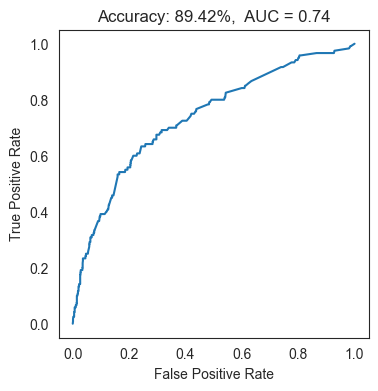

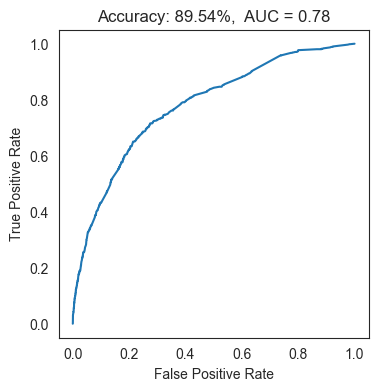

In [5]:

# 预测测试集
model = xgb.XGBClassifier(max_depth=2, min_child_weight=40, gamma=10)

from sklearn.metrics import roc_curve

# 将特征和标签分开
X = df_X.values
y = df_Y.values

# 打乱数据
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
model.save_model(f"{workdir}/xgb_23Jan-Feb_t-wave.xgb")
y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Train Accuracy: %.2f%%" % (accuracy * 100.0))


# 计算准确性
def plot_roc(X_test, y_test, figsize=(4,4)):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[::,1]

    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(1,1,1)
    ax.plot(fpr,tpr)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    auc = roc_auc_score(y_test, y_pred_proba)
    ax.set_title("Accuracy: %.2f%%,  AUC = %.2f" % (accuracy*100, auc))
    return fig

fig = plot_roc(X_test, y_test)
fig.savefig(f"{workdir}/Figure6_A.pdf")
fig = plot_roc(X, y)
fig.savefig(f"{workdir}/Figure6_A-2.pdf")

# interpreting xgboost trees

## get importance

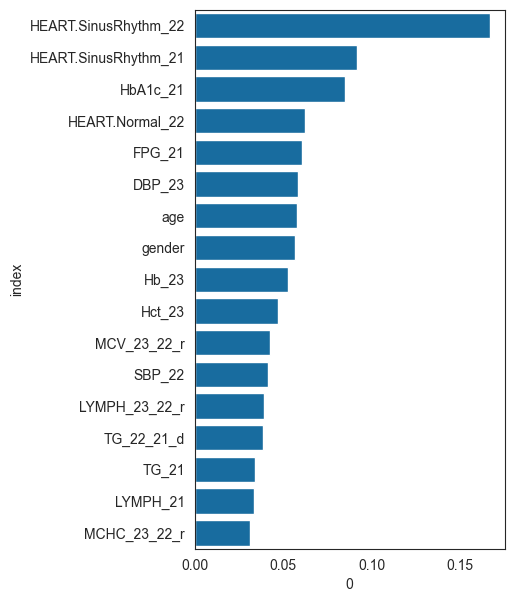

In [6]:
feature_importance = pd.Series(model.feature_importances_, index=df_X.columns)
feature_importance.sort_values(ascending=False, inplace=True)
df_importance = feature_importance[feature_importance>0].reset_index()


fig = plt.figure(figsize=(4,7))
ax = fig.add_subplot(1,1,1)
sns.barplot(data=df_importance, x=0, y="index", ax=ax, color="#0172B6")
fig.savefig(f"{workdir}/Figure6_B.pdf")

## Plot xgb-trees

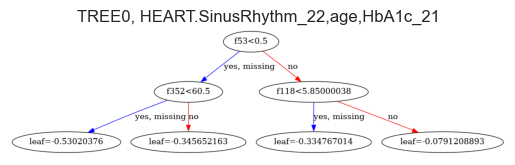

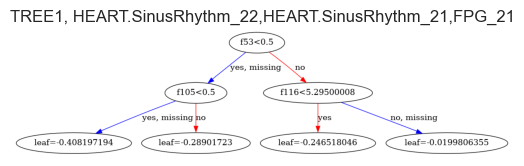

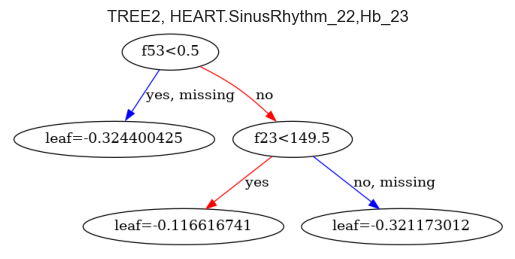

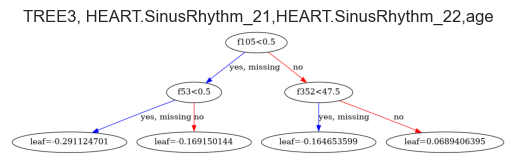

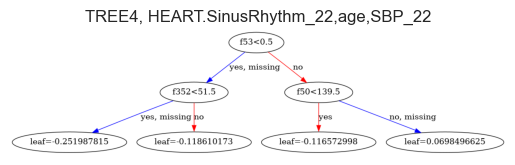

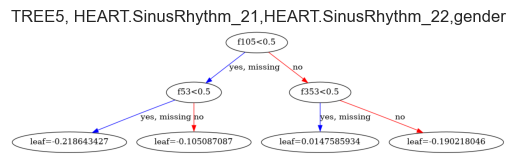

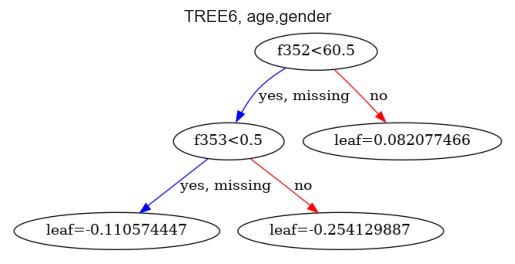

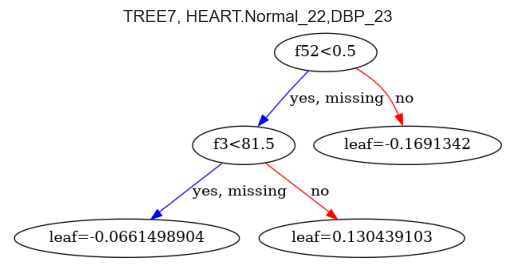

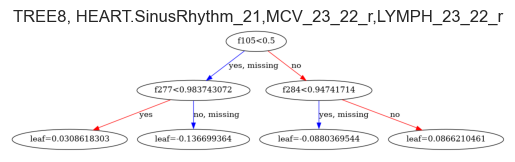

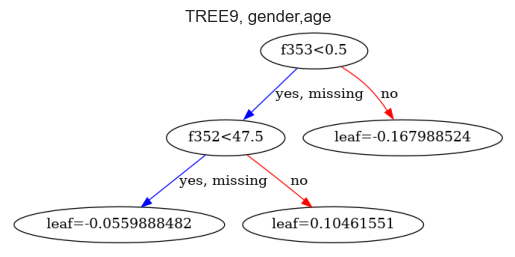

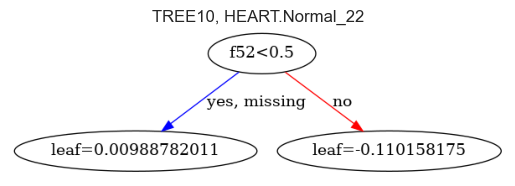

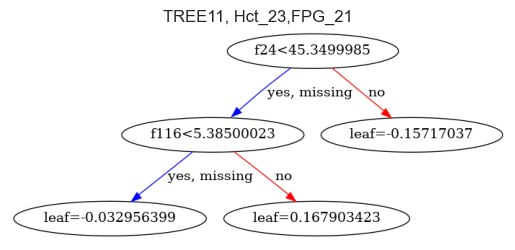

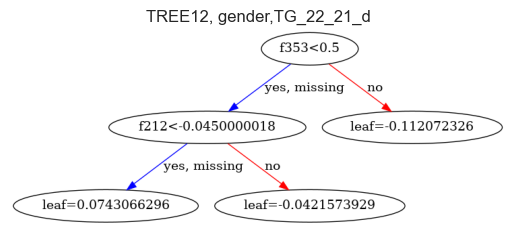

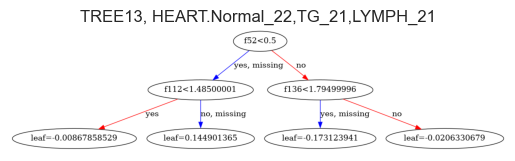

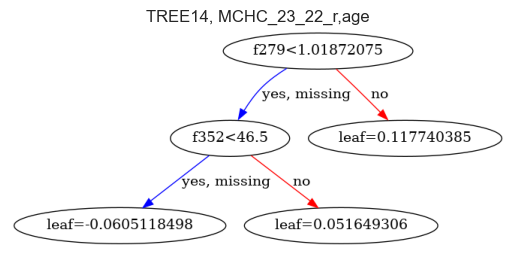

In [7]:
l_nodes = [
    [53, 352, 118],
    [53, 105, 116],
    [53, 23],
    [105, 53, 352],
    [53, 352, 50],
    
    [105, 53, 353],
    [352, 353],
    [52, 3],
    [105, 277, 284],
    [353, 352],

    [52],
    [24, 116],
    [353, 212],
    [52, 112, 136],
    [279, 352],
]
for i_tree,nodes in enumerate(l_nodes):
    s_out = ",".join([f"{df_X.columns[x]}" for x in nodes])
    xgb.plot_tree(model, num_trees=i_tree)
    plt.title(f"TREE{i_tree}, {s_out}")
    plt.show()

## df_t_change from discovery above

```python
plt_sankey.plot_sankey_subplots(df_cnt, [1,2], tag, l_age_groups, l_pairs)
```

In [8]:
df_t_change = pd.melt(
    df_table1plus_3p_revMM[ ["sample_id", 'HEART.T_change', "period", "month", "age_groups","gender"] ],
    id_vars = ["sample_id", "month", "period", "age_groups", "gender"]
).pivot(index=["sample_id","variable", "month", "age_groups", "gender"], 
        columns="period", values="value").reset_index()

l_t_change_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==1)
]["sample_id"]

l_t_norm_2023 = df_t_change[
    (df_t_change["month"].isin([1,2])) & (df_t_change["Test-2023"]==0)
]["sample_id"]

sub_ = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_norm_2023)]
sub_["group"] = "t-norm_2023"
sub_23 = df_table1plus_3p_revMM[df_table1plus_3p_revMM["sample_id"].isin(l_t_change_2023)]
sub_23["group"] = "t-abnorm_2023"

df_t_group = pd.concat([sub_, sub_23])
df_t_group["group_each_year"] = df_t_group.apply(lambda x: f"{x['group']}-{x['period']}" , axis=1)
df_t_group["group_num"] = [ 0 if x=="t-norm_2023" else 1 for x in df_t_group["group"] ]
df_t_group

variable,birthday,year,month,period,gender,sample_id,v000760,v000761,v002266,v000763,...,v0027,v0026,v0032,age,year-month,age_groups,period_age,group,group_each_year,group_num
61301,1993-05-22,2021,2,Control-2021,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,155.2,53.0,NaN,102.0,...,5.3,4.1,63.0,28,2021-02,<30,Control-2021_<30,t-norm_2023,t-norm_2023-Control-2021,0
61305,1993-05-22,2022,2,Control-2022,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,94.0,...,5.3,NaN,69.0,29,2022-02,<30,Control-2022_<30,t-norm_2023,t-norm_2023-Control-2022,0
61309,1993-05-22,2023,2,Test-2023,female,++73/kNuGw58CYBR+pyU2cuvDz1xZNZxVVa5NNZPUg5w1g==,NaN,NaN,NaN,90.0,...,5.9,NaN,63.0,30,2023-02,30-45,Test-2023_30-45,t-norm_2023,t-norm_2023-Test-2023,0
37916,1981-11-11,2021,2,Control-2021,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,162.1,70.2,NaN,89.0,...,10.8,NaN,66.0,40,2021-02,30-45,Control-2021_30-45,t-norm_2023,t-norm_2023-Control-2021,0
37918,1981-11-11,2022,2,Control-2022,female,+/WYJMbwPDjOp33ZRFKX38ytDz5zYtZxVFS4MNVMUw1+uw==,163.6,69.9,NaN,87.0,...,8.9,NaN,61.0,41,2022-02,30-45,Control-2022_30-45,t-norm_2023,t-norm_2023-Control-2022,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9849,1961-09-30,2022,2,Control-2022,male,xWV+pCsYgwDv1ng1eLOXZ8ytDz5zY9ZxWlS5ONdNUwx11g==,NaN,NaN,NaN,58.0,...,8.5,6.6,105.0,61,2022-02,>60,Control-2022_>60,t-abnorm_2023,t-abnorm_2023-Control-2022,1
9852,1961-09-30,2023,2,Test-2023,male,xWV+pCsYgwDv1ng1eLOXZ8ytDz5zY9ZxWlS5ONdNUwx11g==,NaN,NaN,NaN,59.0,...,6.9,4.8,98.0,62,2023-02,>60,Test-2023_>60,t-abnorm_2023,t-abnorm_2023-Test-2023,1
60889,1993-02-07,2021,2,Control-2021,male,xe2iBgbsq0Ayzv5QaitH/sytDzxzYtZxVVa5M9RKUwx1tg==,166.5,69.3,NaN,80.0,...,8.2,3.8,92.0,28,2021-02,<30,Control-2021_<30,t-abnorm_2023,t-abnorm_2023-Control-2021,1
60891,1993-02-07,2022,2,Control-2022,male,xe2iBgbsq0Ayzv5QaitH/sytDzxzYtZxVVa5M9RKUwx1tg==,168.0,68.9,NaN,67.0,...,8.3,NaN,94.0,29,2022-02,<30,Control-2022_<30,t-abnorm_2023,t-abnorm_2023-Control-2022,1


# interpreting xgboost results via the statistical significance tests

## Boxplot with Pvalue: LYMPH

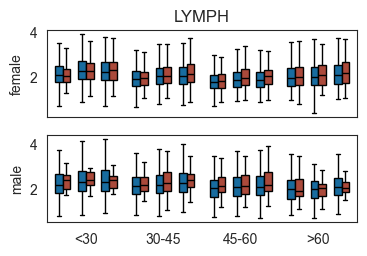

In [9]:
l_tags = [
    'v9057','v9064','v9045','v9058','v9059',
    'v9060','v9061','v9062','v9063','v9065',
    'v9051','v9055','v9089','v9091','v9090',
    'v9046','v9047','v9048','v9049','v9050',
]

l_age_groups = ['<30', '30-45', '45-60', '>60']
hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29"
]

tag = "v9055"
fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups",
                order=l_age_groups,
                hue="group_each_year", y=tag, showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
    # add_stat_annotation(ax, data=df_t_group[(df_t_group["gender"]==gender)], x="age_groups", order=l_age_groups,
    #             hue="group_each_year",y=tag,
    #             box_pairs=[
    #                     ((">60", "t-norm_2023-Test-2023"), (">60", "t-abnorm_2023-Test-2023")),
    #                     (("45-60", "t-norm_2023-Test-2023"), ("45-60", "t-abnorm_2023-Test-2023")),
    #                     (("30-45", "t-norm_2023-Test-2023"), ("30-45", "t-abnorm_2023-Test-2023")),
    #                     (("<30", "t-norm_2023-Test-2023"), ("<30", "t-abnorm_2023-Test-2023")),
    #             ],
    #             test='t-test_ind', text_format='full', loc='inside', verbose=2, comparisons_correction=None
    # )

fig.savefig(f"{workdir}/Figure4_C.pdf")

## Boxplot with Pvalue: HBP

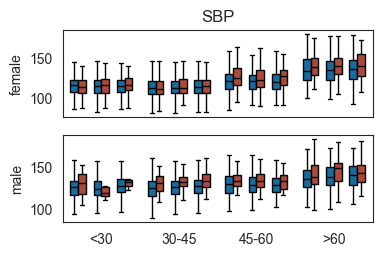

In [10]:
tag = "v000762"
fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups",
                order=l_age_groups,
                hue="group_each_year", y=tag, showfliers = False,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
    
    # add_stat_annotation(ax, data=df_t_group[(df_t_group["gender"]==gender)], x="age_groups", order=l_age_groups,
    #             hue="group_each_year",y=tag,
    #             box_pairs=[
    #                     ((">60", "t-norm_2023-Test-2023"), (">60", "t-abnorm_2023-Test-2023")),
    #                     (("45-60", "t-norm_2023-Test-2023"), ("45-60", "t-abnorm_2023-Test-2023")),
    #                     (("30-45", "t-norm_2023-Test-2023"), ("30-45", "t-abnorm_2023-Test-2023")),
    #                     (("<30", "t-norm_2023-Test-2023"), ("<30", "t-abnorm_2023-Test-2023")),
    #             ],
    #             test='t-test_ind', text_format='full', loc='inside', verbose=2, comparisons_correction=None
    # )
    
# fig.savefig(f"{workdir}/Figure5_C-1.pdf")

## Barplot with Chi Square Exam, LIVER.Steatosis

In [11]:
def extract_chi2_table(df_t_group, gender, tag, l_age_group_subs=None, compares=None):
    if l_age_group_subs is None:
        l_age_group_subs = ["<30", "30-45"]

    if compares is None:
        compares = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

    np_table = np.zeros([2,2])
    for age in l_age_group_subs:
        arr1 = df_t_group[[tag, "group_num", "age_groups"]][
                        (df_t_group["gender"]==gender) &
                        (df_t_group["age_groups"]==age) &
                        (df_t_group["group_each_year"]==compares[0])
        ][tag].dropna().values
        arr2 = df_t_group[[tag, "group_num", "age_groups"]][
                        (df_t_group["gender"]==gender) &
                        (df_t_group["age_groups"]==age) &
                        (df_t_group["group_each_year"]==compares[1])
        ][tag].dropna().values
        
        np_table += np.array([
            [arr1.sum(), len(arr1)-arr1.sum()],
            [arr2.sum(), len(arr2)-arr2.sum()],
        ])
    
    return np_table


def print_chi2_table(df_t_group, gender, tag, l_age_group_subs=None, ax=None, compares=None):
    if l_age_group_subs is None:
        l_age_group_subs = ["<30", "30-45"]

    if compares is None:
        compares = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

    ax.axis('tight')
    ax.axis('off')
    np_table = extract_chi2_table(df_t_group, gender, tag, l_age_group_subs, compares)

    chi = scipy.stats.chi2_contingency(np_table)
    np_exp = chi.expected_freq
    list_table = [
        [f"{np_table[0,0]:.0f},({np_exp[0,0]:.2f})", f"{np_table[0,1]:.0f},({np_exp[0,1]:.0f})", f"{np_table[0,0]+np_table[0,1]:.0f}"],
        [f"{np_table[1,0]:.0f},({np_exp[1,0]:.2f})", f"{np_table[1,1]:.0f},({np_exp[1,1]:.0f})", f"{np_table[1,0]+np_table[1,1]:.0f}"],
        [f"{np_table[0,0]+np_table[1,0]:.0f}", f"{np_table[0,1]+np_table[1,1]:.0f}", f"{np_table[0,0]+np_table[1,0]+np_table[0,1]+np_table[1,1]:.0f}"],
    ]
    ax.set_title(f"{l_age_group_subs}, X2 = {chi.pvalue:.2e}")
    the_table = ax.table(cellText=list_table, 
                colLabels=[tag, f"No-{tag}", "rowSum"], 
                rowLabels=["T-wave-Normal", "T-wave-Abnormal", "colSum"],
                edges="open",             
                loc="center"
            )
    the_table.auto_set_font_size(False)
    the_table.set_fontsize(7)

<Figure size 800x500 with 0 Axes>

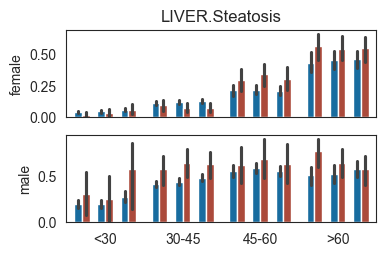

In [12]:
fig = plt.figure(figsize=(8,5))
tag = "LIVER.Steatosis"

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]

idx = 0
gender = "female"

fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.barplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag,# showfliers = False,
                order=l_age_groups,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        
fig.savefig(f"{workdir}/FigureS6_B.pdf")

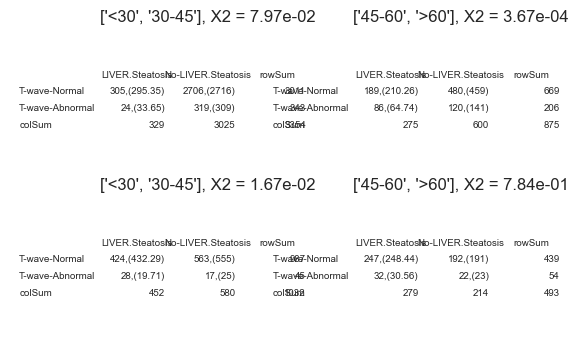

In [13]:
tag = "LIVER.Steatosis"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax)

fig.savefig(f"{workdir}/Table2.pdf")

## Barplot with Chi Square Exam, LUNG.GroundGlassOpacity in 2022

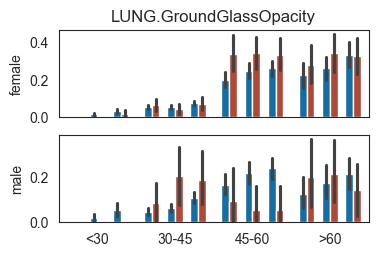

In [14]:

tag = "LUNG.GroundGlassOpacity"

l_age_groups = ['<30', '30-45', '45-60', '>60']
hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29", "#000000",
        "#0172B6", "#BD3C29"
]

fig = plt.figure(figsize=(4,2.5))
for idx,gender in enumerate(["female", "male"]):
    ax = fig.add_subplot(2,1,1+idx)
    sns.barplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", 
                hue="group_each_year", y=tag,# showfliers = False,
                order=l_age_groups,
                hue_order=hue_order, palette=pal, ax=ax)

    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel(gender)
    if idx < 1:
        ax.set_xticks([])
        ax.set_xticklabels([])
        ax.set_title(parse_dict_with_default(tag, rename_dict))

df_t_group[(df_t_group["gender"]==gender)][[tag, "group_num", "age_groups"]].dropna().pivot_table(
    index="group_num", columns="age_groups", aggfunc=len, values=tag
)

fig.savefig(f"{workdir}/FigureS6_C.pdf")


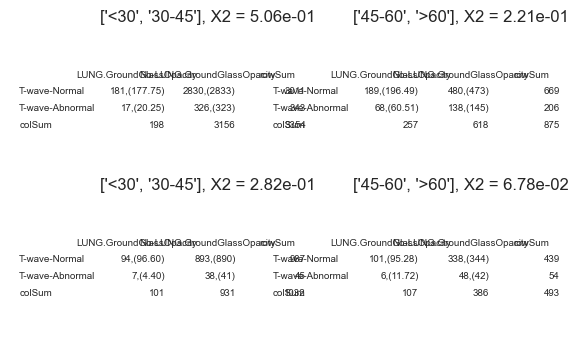

In [15]:

cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]
tag = "LUNG.GroundGlassOpacity"
gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/.FigureS6_D.pdf")


## Barplot with Chi Square Exam, is SBP > 139.5

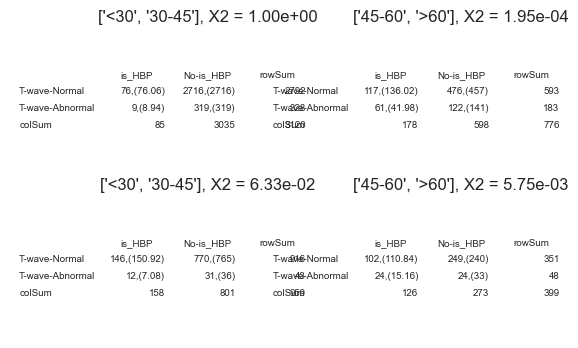

In [16]:
cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

df_t_group["is_HBP"] = [1 if x > 139.5 else 0 for x in df_t_group["v000762"]]
df_t_group["is_HBP"][ pd.isna(df_t_group["v000762"]) ] = pd.NA
tag = "is_HBP"


gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

fig.savefig(f"{workdir}/Table1.pdf")

## Barplot with Chi Square Exam, is FBG > 5.6

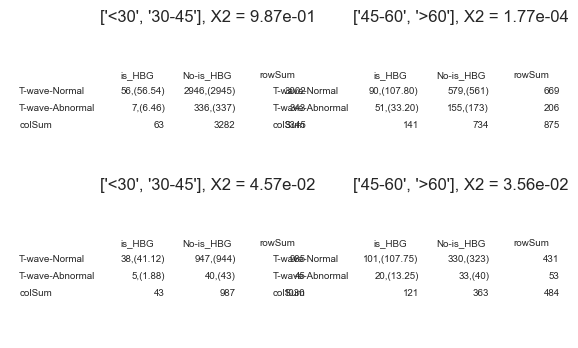

In [17]:
cmp = ["t-norm_2023-Test-2023", "t-abnorm_2023-Test-2023"]

df_t_group["is_HBG"] = [1 if x > 5.6 else 0 for x in df_t_group["v0023"]]
df_t_group["is_HBG"][ pd.isna(df_t_group["v0023"]) ] = pd.NA
tag = "is_HBG"


gender = "female"
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(2,2,1)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,2)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)

gender = "male"
ax = fig.add_subplot(2,2,3)
print_chi2_table(df_t_group, gender, tag, ["<30", "30-45"], ax, compares = cmp)
ax = fig.add_subplot(2,2,4)
print_chi2_table(df_t_group, gender, tag, ["45-60", ">60"], ax, compares = cmp)
fig.savefig(f"{workdir}/Table3.pdf")

## Other boxplots

gender                      female                         male                \
age_groups                     <30   30-45  45-60    >60    <30  30-45  45-60   
group_each_year                                                                 
t-abnorm_2023-Control-2021   172.0   191.0  101.0   83.0   13.0   34.0   20.0   
t-abnorm_2023-Control-2022   145.0   207.0  108.0   88.0    8.0   39.0   18.0   
t-abnorm_2023-Test-2023      132.0   211.0  111.0   95.0    7.0   38.0   18.0   
t-norm_2023-Control-2021    1455.0  1645.0  410.0  152.0  361.0  681.0  271.0   
t-norm_2023-Control-2022    1299.0  1770.0  436.0  167.0  302.0  703.0  298.0   
t-norm_2023-Test-2023       1164.0  1837.0  479.0  189.0  245.0  730.0  310.0   
t-abnorm_2023-Control-2021   173.0   191.0  101.0   83.0   13.0   35.0   21.0   
t-abnorm_2023-Control-2022   146.0   207.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      132.0   211.0  111.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1461.0  1646.0  410.0  152.0  366.0  686.0  275.0   
t-norm_2023-Control-2022    1299.0  1772.0  436.0  168.0  306.0  709.0  301.0   
t-norm_2023-Test-2023       1164.0  1838.0  480.0  189.0  250.0  735.0  312.0   
t-abnorm_2023-Control-2021   171.0   183.0   93.0   81.0   12.0   31.0   19.0   
t-abnorm_2023-Control-2022   142.0   194.0   97.0   84.0    8.0   34.0   17.0   
t-abnorm_2023-Test-2023      130.0   198.0   95.0   88.0    7.0   36.0   18.0   
t-norm_2023-Control-2021    1441.0  1536.0  370.0  147.0  359.0  634.0  222.0   
t-norm_2023-Control-2022    1275.0  1630.0  394.0  156.0  300.0  662.0  256.0   
t-norm_2023-Test-2023       1135.0  1657.0  425.0  168.0  244.0  672.0  247.0   
t-abnorm_2023-Control-2021   120.0   179.0   98.0   79.0    9.0   32.0   20.0   
t-abnorm_2023-Control-2022     NaN    26.0   33.0   21.0    1.0   11.0    9.0   
t-abnorm_2023-Test-2023        1.0    23.0   36.0   29.0    2.0    9.0   10.0   
t-norm_2023-Control-2021     908.0  1535.0  395.0  142.0  216.0  607.0  257.0   
t-norm_2023-Control-2022      20.0   178.0  164.0   53.0   15.0  164.0  205.0   
t-norm_2023-Test-2023         12.0   191.0  177.0   61.0    9.0  166.0  214.0   
t-abnorm_2023-Control-2021   173.0   191.0  101.0   83.0   13.0   35.0   21.0   
t-abnorm_2023-Control-2022   146.0   207.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      132.0   211.0  111.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1461.0  1646.0  410.0  152.0  366.0  686.0  274.0   
t-norm_2023-Control-2022    1299.0  1772.0  436.0  168.0  306.0  709.0  301.0   
t-norm_2023-Test-2023       1164.0  1838.0  480.0  189.0  250.0  735.0  312.0   
t-abnorm_2023-Control-2021   173.0   191.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   146.0   207.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      132.0   211.0  110.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1461.0  1647.0  410.0  152.0  366.0  686.0  275.0   
t-norm_2023-Control-2022    1299.0  1772.0  436.0  167.0  306.0  710.0  302.0   
t-norm_2023-Test-2023       1162.0  1836.0  480.0  188.0  250.0  736.0  313.0   
t-abnorm_2023-Control-2021   173.0   191.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   146.0   207.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      132.0   211.0  110.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1461.0  1647.0  410.0  152.0  366.0  686.0  275.0   
t-norm_2023-Control-2022    1299.0  1772.0  436.0  167.0  306.0  710.0  302.0   
t-norm_2023-Test-2023       1162.0  1836.0  480.0  188.0  250.0  736.0  313.0   
t-abnorm_2023-Control-2021   173.0   191.0  101.0   83.0   13.0   35.0   20.0   
t-abnorm_2023-Control-2022   146.0   207.0  108.0   88.0    8.0   39.0   19.0   
t-abnorm_2023-Test-2023      132.0   211.0  110.0   95.0    7.0   38.0   19.0   
t-norm_2023-Control-2021    1461.0  1647.0  410.0  152.0  366.0  686.0  275.0   
t-norm_2023-Control-2022    129

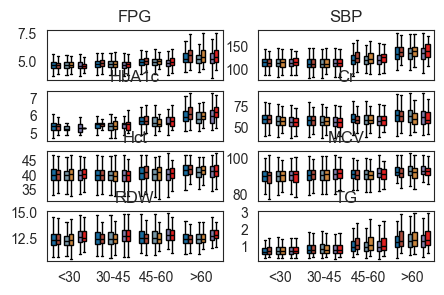

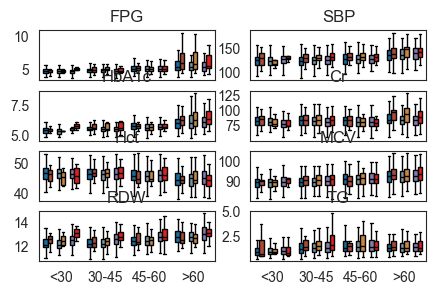

In [18]:
# from utils import parse_dict_with_default
l_orders = [
    "v0023", 'v000762', "v1164", "v0032", 
    "v9059", "v9060", "v9063", "v0009",
]

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021", "",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022","",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [ "#0172B6", "#BD3C29", "#000000",
        "#6F99AD", "#E18727", "#000000",
        "#7876B1", "#FF0000"]

new_cols =  pd.MultiIndex.from_tuples([
            (  'female',   '<30'),        
            (  'female', '30-45'),
            (  'female', '45-60'),
            (  'female',   '>60'),
            (    'male',   '<30'),
            (    'male', '30-45'),
            (    'male', '45-60'),
            (    'male',   '>60'),
            (     'tag',      ''),
            ('tag_name',      '')
])


n_col = 2
l_df_box_n = []
for gender in ["female", "male"]:
    fig = plt.figure(figsize=(5,3))
    for idx,tag in enumerate(l_orders):
        if gender == "male":
            l_df_box_n.append(df_n_boxes)

        ax = fig.add_subplot(4,n_col,1+idx)
        sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], x="age_groups", hue="group_each_year", y=tag, showfliers = False,
                    order=l_age_groups,
                    hue_order=hue_order, palette=pal, ax=ax)
            
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")
        if idx < len(l_orders) - n_col:
            ax.set_xticks([])
            ax.set_xticklabels([])
        
        l_col_used = ["gender", "age_groups", "group_each_year"]
        df_n_boxes = df_t_group[l_col_used + [tag]].dropna()[l_col_used].pivot_table(
                        index="group_each_year", columns=["gender", "age_groups"], aggfunc=len
        )
        df_n_boxes["tag"] = tag
        df_n_boxes["tag_name"] = parse_dict_with_default(tag, rename_dict)
    
    fig.savefig(f"{workdir}/FigureS6_A-{gender}.pdf")

df_res = pd.concat(l_df_box_n)
df_res[new_cols]

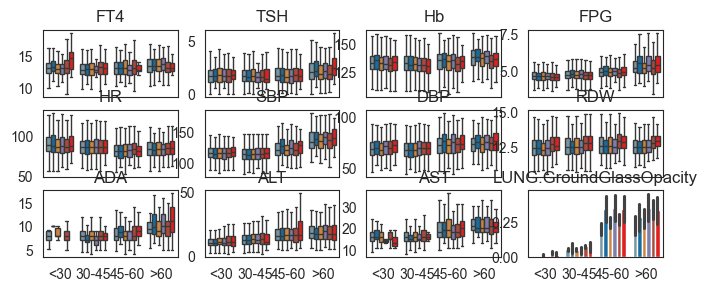

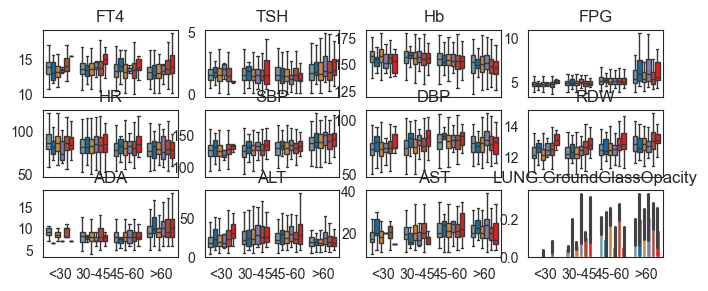

In [19]:
from utils import parse_dict_with_default
l_orders = [
    'v9462', 'v9461', "v9058", "v0023",
    'v000763','v000762', 'v002161', 'v9063',
    "v1162",'v0017', 'v0045', "LUNG.GroundGlassOpacity",
]

hue_order = [
    "t-norm_2023-Control-2021","t-abnorm_2023-Control-2021",
    "t-norm_2023-Control-2022","t-abnorm_2023-Control-2022",
    "t-norm_2023-Test-2023",   "t-abnorm_2023-Test-2023"
]
pal = [ "#6F99AD", "#0172B6", "#E18727",  "#7876B1",  "#BD3C29", "#FF0000"]
for gender in ["female", "male"]:
    fig = plt.figure(figsize=(8,4))
    for idx,tag in enumerate(l_orders):
        ax = fig.add_subplot(4,4,1+idx)
        if idx != len(l_orders) -1:
            sns.boxplot(df_t_group[(df_t_group["gender"]==gender)], order=l_age_groups,
                            x="age_groups", hue="group_each_year", y=tag, showfliers = False,
                            hue_order=hue_order, palette=pal, ax=ax)
        else:
            sns.barplot(df_t_group[(df_t_group["gender"]==gender)], order=l_age_groups,
                            x="age_groups", hue="group_each_year", y=tag,
                            hue_order=hue_order, palette=pal, ax=ax)
            
        ax.set_title(parse_dict_with_default(tag, rename_dict))
        ax.get_legend().remove()
        ax.set_xlabel("")
        ax.set_ylabel("")
        if idx < len(l_orders) - 4:
            ax.set_xticks([])
            ax.set_xticklabels([])